# Module 2

In [1]:
#===============#
# PCG algorithm #
#===============#

import numpy as np
import numpy.linalg as la

# These are the functions to be implemented in 1a
def PCG(A_func,b,x0,tol,Precond):
    """
    A_func represents the matrix A in Ax = b.
    Likewise, the function b_def can be used to construct b
    """
    N=len(x0)
    x=x0
    r = b - A_func(x)
    z = Precond(r)
    p = z
    Ax = A_func(x)
    zr = np.inner(z,r)
    rnrm = la.norm(r,2)
    iter=0
    while rnrm > tol and iter < N:
        iter+=1
        Ap = A_func(p)
        alpha = zr/np.inner(p,Ap)
        x = x + alpha*p
        r = r - alpha*Ap
        z = Precond(r)
        zr1 = np.inner(z,r)
        beta = zr1/zr
        p=z+beta*p
        zr=zr1
        rnrm = la.norm(r,2)
        
    return x, iter, r
    
    
def PrecNull(r):
    return r

def PrecJac(p):
    n=len(p)
    u=np.zeros((n,))
    for k in range(nJac):
        r=p-A_func(u)
        u=u+omega*0.25*r
    return u

def A_func(v):
    n2=len(v)
    n=int(np.sqrt(n2))
    if n**2 != n2:
        sys.exit("Size of vector must be a square")
    M=np.zeros((n+2,n+2))
    M[1:n+1,1:n+1]=np.reshape(v,(n,n))
    AM = 4*M[1:n+1,1:n+1]-M[:n,1:n+1]-M[2:n+2,1:n+1]-M[1:n+1,:n]-M[1:n+1,2:n+2]
    Av = np.reshape(AM,(n2,))
    return Av

def b_def(n):
    h = 1/(n+1)
    X = np.linspace(h,1-h,n)
    Y=X
    B = np.outer( 16*X**2*(1-X)**2, 16*Y**2*(1-Y)**2 )
    b = np.reshape(B, (n**2,))
    return B,b



In [ ]:
#==========================#
# LU with partial pivoting #
#==========================#

def mylu(A):
    """
    Calculates the LU factorisation and stores it in a single matrix
    Returns LU and pivot matrx
    """
    n,m = A.shape

    p = np.zeros(n)
    for i in range(n):
        p[i] = i
    p = p.astype(int)


    for k in range(n-1): 
        #find pivot
        pivot = np.argmax(abs(A[p[k:], k])) + k
        
        #swap
        p[pivot], p[k] = p[k], p[pivot]
               
        #multipliers
        mults = A[p[k+1:],k] / A[p[k],k]
        
        #elimination
        A[p[k+1:], k+1:] = A[p[k+1:],k+1:] - np.outer(mults,A[p[k],k+1:])
        A[p[k+1:], k] = mults
        
    return A,p


def forward_subs(LU,P,b):
    ''' Forward substitution algorithm
    Input:
        LU contains both L and U, even if only L is needed here 
        P Integer permutation vector
        b Vector with right hand side in the problem to be solved
    Output:
        c The solution to the linear lower triangular system Lc=b 
    '''
    n, m = LU.shape
    Pb = b[P]
    c = np.zeros(n)
    c[0] = Pb[0]
    for k in range(1,n):
        c[k] = Pb[k] - LU[P[k],0:k] @ c[0:k]
        
    return c

def backward_subs(LU,P,c):
    ''' Backward substitution algorithm
    Input:
        LU contains both L and U, even though just U is needed here
        P Integer permutation vector
        c Vector containing right hand side, i.e. the function solves Ux=c
    Output:
        x Solution to the linear upper triangular system Ux = c
    '''
    n,m = LU.shape
    x = np.zeros(n)
    x[n-1] = c[n-1]/LU[P[n-1],n-1]
    for k in range(n-1,0,-1):
        x[k-1] = (c[k-1]-LU[P[k-1],k:] @ x[k:])/LU[P[k-1],k-1]
        
    return x


def getAb():
    A=np.array([[0.3050, 0.5399, 0.9831, 0.4039, 0.1962],
                [0.2563, -0.1986, 0.7903, 0.6807, 0.5544],
                [0.7746, 0.6253, -0.1458, 0.1704,  0.5167],
                [0.4406, 0.9256, 0.4361, -0.2254, 0.7784],
                [0.4568, 0.2108, 0.6006, 0.3677, -0.8922]])
    b=np.array([0.9876,-1.231,0.0987,-0.5544,0.7712])
    return A,b




#Example:
A, b = getAb()
LU,p = mylu(A)
c = forward_subs(LU,p,b)
x = backward_subs(LU,p,c)

# Module 4

In [42]:
'''
Eksempel: Baklengs Euler kombinert med Newtons formel for systemer
'''
import numpy as np
import numpy.linalg as la
import autograd.numpy as grad
from autograd import jacobian
import math


def sNewton(f,x0,tol):
    iter=0
    maxiter=100
    Df=jacobian(f)      
    est=2.*tol
    x=x0
    while est>tol and iter<maxiter:
        iter=iter+1
        delta=la.solve(Df(x),-f(x))
        est=la.norm(delta)
        x=x+delta
    return x, iter


def beuler_step(yn,f,h,tol):
    ''' Ta ett skritt med baklengs Euler der 
    yn: initialverdien til skrittet
    P: En klasse som inneholder to funksjoner
        P.f: funksjon som tar ett argument y (numpy array) og returnerer dy=y'=f(y)  (numpy array)
        P.Jf: funksjon som tar ett argument y (numpy array) og returnerer jacobi-matrisen J_f(y) (2D numpy array)
    h: Skrittlengde
    tol: toleranse i Newtoniterasjonen
    Returnerer løsningen etter ett skritt
    '''
    m=yn.size
    z=yn
    newton_error=tol+1
    k=0
    I = np.eye(m)
    Df = jacobian(f)
    while newton_error > tol:
        A=I-h*Df(z)
        b=yn+h*f(z)-z
        delta = np.linalg.solve(A,b)
        z=z+delta
        newton_error= np.linalg.norm(delta)
        k+=1
        if k>1000:
            print('Too many iterations')
            break    
    return z

def beuler(y0,f,h,tol,nsteps):
    ''' Ta nsteps skritt med baklengs Euler
    y0: StStartverdien, numpy-array
    P: Brukerdefinert klasse som beskrevet i beuler_step
    h: Skrittlengde brukt i integrasjonen (se beuler_step)
    tol: Toleranse brukt i Newtoniterasjonen (se beuler_step)
    nsteps: Antall skritt i integrasjonen, løsningsintevallet er [0,h*nsteps]
    Returner Y, et 2x(nsteps+1) numpy array der kolonne k er [yk, yk']^T, numerisk løsning ved tid t=k*h
    '''
    
    m=y0.size
    Y = np.zeros((m,nsteps+1))
    Y[:,0]=y0
    for k in range(nsteps):
        Y[:,k+1]=beuler_step(Y[:,k],f,h,tol)
        
    return Y

"""
def f(y,mu = 5):
    return np.array([y[1],mu*(1-y[0]**2)*y[1]-y[0]])

y0=np.array([2,0])
tol=1e-6
h=0.01
nsteps=1500
Y=beuler(y0,f,h,tol,nsteps)
plt.plot(Y[0,:],Y[1,:])
plt.show()
print('Y[:,1000]=', Y[:,1000])

"""


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

# Module 5


[[-0.5  0.5]
 [ 0.  -1.5]
 [ 1.5  0. ]
 [ 0.   1. ]]
[-1.  0.  1.]


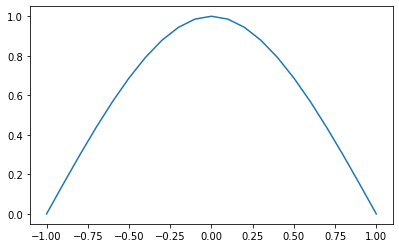

In [26]:
#Splines

from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt



x = np.array([-1,0,1]) #knots
y = np.array([0,1,0]) #f-values at knots

spline = interpolate.CubicSpline(x,y,bc_type = 'natural')
print(spline.c)
#The polynimial is written in the loca power basis:
#S = sum(c[m, i] * (xp - x[i])**(k-m) for m in range(k+1))


xs = np.arange(-1, 1.1, 0.1)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(xs, spline(xs), label="S")
plt.show()



# Module 6

In [28]:
#=====================#
# Romberg integration #
#=====================#

import numpy as np

def trapes(f,a,b,n):
    h= float(b-a)/n
    result = h/2.0 *(f(a)+f(b))
    for k in range(1,n):
        result += f(a+k*h)
    return h*result

def midpoint(f, a, b, n):
    h = float(b-a)/n
    result = 0
    for i in range(n):
        result += f((a + h/2.0) + i*h)
    result *= h
    return result



def romberg(f,a,b,n):
    A = np.zeros((n,n))
    A[0,0] = trapes(f,a,b,1)
    m = 0
    for i in range(1,n):
        U = midpoint(f,a,b,2**m)
        A[i,0] = 0.5 * (A[i-1,0] + U)
        
        for j in range(0,m+1):
            A[i,j+1] = (4**(j+1) * A[i,j] - A[i-1,j])/(4**(j+1)-1)
            
        err = abs(A[i,i] - A[i,i-1])
        m += 1
    
    #print solution:
    print(A)
    print("\n")
    print("Error: " + str(err))
    

def f(x):
    return np.sqrt(x)*np.sin(x)

romberg(f,0,1,4)
    
    

[[0.42073549 0.         0.         0.        ]
 [0.37987027 0.36624853 0.         0.        ]
 [0.36843975 0.36462958 0.36452165 0.        ]
 [0.36533307 0.36429751 0.36427538 0.36427147]]


Error: 3.909047339378802e-06
